In [21]:
import pandas as pd
import folium
import os
import matplotlib.pyplot as plt

In [22]:
# 读取数据
df = pd.read_excel("./储能火灾事故分析.xlsx")

# Delete NA rows
df = df[df['经纬度坐标'].notna()]

# 假设列名是 'Custom location (Lat, Lon)'
df[['Latitude', 'Longitude']] = df['经纬度坐标'].str.split(',', expand=True)

# 转换为浮点数
df['Latitude'] = pd.to_numeric(df['Latitude'].str.replace('\ufeff', '').str.strip(), errors='coerce')
df['Longitude'] = pd.to_numeric(df['Longitude'].str.strip(), errors='coerce')

In [23]:
# 定义分类函数
def classify_battery_type(x):
    if pd.isna(x):
        return 'unknown'
    
    x = str(x).lower().replace(' ', '')  # 转小写并去空格
    
    if any(keyword in x for keyword in ['磷酸铁锂', 'lfp','LFP']):
        return 'LFP'
    elif any(keyword in x for keyword in ['三元', 'nmc', 'nca']):
        return 'NMC/NCA'
    elif any(keyword in x for keyword in ['NaS']):
        return 'NaS'
    elif any(keyword in x for keyword in ['PbA']):
        return 'PbA'
    else:
        return 'other'

# 应用分类函数
df['电池类型分类'] = df['电池类型（三元/铁锂）'].apply(classify_battery_type)

In [24]:
# 确保时间列是 datetime 类型
df['时间'] = df['时间'].astype(str)
df['时间'] = pd.to_datetime(df['时间'], format="%Y-%m-%d", errors='coerce')

# 按时间升序排序
df = df.sort_values(by='时间', ascending=True).reset_index(drop=True)

In [25]:
df

,时间,地点,经纬度坐标,电池类型（三元/铁锂）,运营商/投资商,规模 MWh,电站启用时间,直接原因,间接原因,BMS,消防系统,电气故障,运维操作不当,不明,经济损失,人员伤亡,网站来源,Latitude,Longitude,电池类型分类
0,2011-09-21,"Japan, Ibaraki Prefecture","36.2869536,140.4703384",NGK [NaS],NaN,NaN,NaN,单体电池起火,电池包内短路,NaN,NaN,NaN,NaN,1.0,NaN,无,https://epri.box.com/shared/static/8vaouiiy46l...,36.286954,140.470338,other
1,2012-08-01,"US, HI, Kahuku","21.679124,-157.94838",Xtreme [PbA],NaN,10MWh,1.5,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,无,https://epri.box.com/shared/static/xftkj6mfyet...,21.679124,-157.948380,other
2,2012-11-26,"US, AZ, Flagstaff","35.1987522,-111.651822",NaN,NaN,1.5MWh,1.5,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,无,https://epri.box.com/shared/static/pq87s90sqqk...,35.198752,-111.651822,unknown
3,2013-07-03,"US, WA, Port Angeles","48.118146,-123.430741",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,无,https://epri.box.com/shared/static/b2cgyb29y5r...,48.118146,-123.430741,unknown
4,2016-08-10,威斯康星州富兰克林市,"42.888627,-88.0384183",三元锂,三星SDI（推测）,系统处于半组装状态,未投运,电池热失控,电池保护系统不足和操作管理缺陷,NaN,NaN,NaN,1.0,NaN,300万美元,1名消防员受伤,https://www.greentechmedia.com/articles/read/s...,42.888627,-88.038418,NMC/NCA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108,2025-02-19,英国埃塞克斯郡 蒂尔伯里,"51.4631174,0.3643896",不确定（电池供应商有阳光电源，LG，三星，BYD）,Statera,300MW/600MWh,在建,电池单元起火,/,NaN,NaN,NaN,NaN,1.0,/,无,https://stateraenergy.co.uk/projects/thurrock-...,51.463117,0.364390,other
109,2025-02-21,韩国忠清南道天安市木川邑,"36.7885,127.2126",/,/,/,/,NaN,NaN,NaN,NaN,NaN,NaN,1.0,5.56亿韩元,无,NaN,36.788500,127.212600,other
110,2025-02-21,"The Overhill project，Rothiernorman, Scotland苏格兰","57.4113653,-2.4644314",LFP,Green enesys,50MW,2024年年底,电池舱单元故障,施工时产生了故障,NaN,NaN,1.0,NaN,NaN,/,无,https://greenenesys.com/en/projects/overhill-f...,57.411365,-2.464431,LFP
111,2025-03-09,韩国全罗南道康津郡,"34.639,126.7680",三元锂电池,NaN,NaN,NaN,电池过热（详细原因不明,/,NaN,NaN,NaN,NaN,1.0,"100亿韩元(约4,970万元人民币)",消防员受伤,NaN,34.639000,126.768000,NMC/NCA


In [29]:
df["电池类型分类"].unique()

array(['other', 'unknown', 'NMC/NCA', 'LFP'], dtype=object)

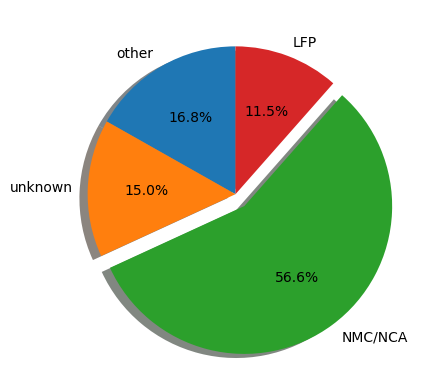

In [31]:
#Pie chart
labels = df["电池类型分类"].unique()
sizes = []
for ele in df["电池类型分类"].unique():
    sizes.append(sum(df["电池类型分类"] == ele))

explode = (0, 0, 0.1, 0)  
fig, ax = plt.subplots()
ax.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
       shadow={'ox': -0.04, 'edgecolor': 'none', 'shade': 0.9}, startangle=90)
plt.show()

In [ ]:
#Bar Chart

In [131]:
m = folium.Map(location=[20, 0], zoom_start=2)

for _, row in df.iterrows():
    popup_text = f"""
    <b>Event Date:</b> {row['时间']}<br>
    <b>Capacity (MWh):</b> {row['规模 MWh']}<br>
    <b>Battery Modules:</b> {row['电池类型（三元/铁锂）']}<br>
    <b>Root Cause:</b> {row['直接原因']}
    """
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=popup_text,
        icon=folium.Icon(color='red', icon='fire')
    ).add_to(m)

# 输出 HTML 文件到 templates 文件夹（供 Flask 使用）
os.makedirs("templates", exist_ok=True)

In [132]:
m.save("templates/storage_fire_map.html")